In [2]:
import numpy as np
from data_generator import BaseDataset
from dataset import DatasetGenerator
import matplotlib.pyplot as plt
import os
from eval_model import eval_pearsonsr, scale_preds
from keras.src.optimizers import Adam
from model import ModelTrainer
from sklearn.model_selection import KFold
from models_repo.LinearRegressor import LinearRegressor
from models_repo.LSTMRegressor import LSTMRegressor2L, LSTMRegressor

os.environ["CUDA_VISIBLE_DEVICES"] = "1"


2024-05-21 18:43:42.733314: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-21 18:43:42.733396: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-21 18:43:42.733430: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-21 18:43:42.767946: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
data_path = 'data'
dataset_path = 'dataset'
train_scalers_path = 'train-scalers'
columns = ['date', 'RSAM', 'T_olb', 'Ru_olb', 'P_olb', 'Rn_olb', 'T_msa',
           'Ru_msa', 'P_msa', 'Rn_msa', 'displacement (cm)',
           'background seismicity']
"""
    In questo punto carico i dati con i generator e li trasformo in X,y
"""
# dataset
dataset = BaseDataset(data_path=dataset_path)

In [ ]:
# carico i dati, li divido e creo i generators
train_filenames, test_filenames = dataset.load_data(shuffle=False)
# li carico già divisi, non serve più splittarli
train_generator, test_generator, _, __ = dataset.generate_data(train_filenames, test_filenames)
# ottengo X_train,y_train ed X_test, y_test
X_train, y_train = dataset.generator_to_Xy(train_generator)
X_test, y_test = dataset.generator_to_Xy(test_generator)

In [ ]:
rn = DatasetGenerator.get_ts_from_ds(X_train, 0)
rn_test = DatasetGenerator.get_ts_from_ds(X_test, 0)

In [ ]:
plt.figure(figsize=(20,6))
plt.plot(rn)
plt.figure(figsize=(20,6))
plt.plot(rn_test)

In [4]:
import string
import hashlib
import random
def generate_model_name():
    # Convert hyperparameters to a string
    letters = string.ascii_lowercase  # Use lowercase letters
    hyperparameters = ''.join(random.choice(letters) for i in range(20))

    hyperparameters_str = str(hyperparameters) + str(random.randint(1,1000))
    # Generate SHA-256 hash
    hash_object = hashlib.sha256(hyperparameters_str.encode())
    model_name = hash_object.hexdigest()[:8]  # Take first 8 characters for readability

    return model_name

(2029, 2)


2024-05-21 18:43:54.948152: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15000 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:6d:00.0, compute capability: 6.0


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30, 6)]           0         
                                                                 
 lstm (LSTM)                 (None, 64)                18176     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 18241 (71.25 KB)
Trainable params: 18241 (71.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/512


2024-05-21 18:43:58.816625: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700


20/25 [=======================>......] - ETA: 0s - loss: 0.0149 - mse: 0.0149
Epoch 1: val_loss improved from inf to 0.00598, saving model to saved_model/293c82c4.x
INFO:tensorflow:Assets written to: saved_model/293c82c4.x/assets


INFO:tensorflow:Assets written to: saved_model/293c82c4.x/assets


25/25 [==============================] - 6s 113ms/step - loss: 0.0139 - mse: 0.0139 - val_loss: 0.0060 - val_mse: 0.0060 - lr: 0.0010
Epoch 2/512
20/25 [=======================>......] - ETA: 0s - loss: 0.0079 - mse: 0.0079
Epoch 2: val_loss improved from 0.00598 to 0.00510, saving model to saved_model/293c82c4.x
INFO:tensorflow:Assets written to: saved_model/293c82c4.x/assets


INFO:tensorflow:Assets written to: saved_model/293c82c4.x/assets


25/25 [==============================] - 3s 103ms/step - loss: 0.0077 - mse: 0.0077 - val_loss: 0.0051 - val_mse: 0.0051 - lr: 0.0010
Epoch 3/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0082 - mse: 0.0082
Epoch 3: val_loss did not improve from 0.00510
25/25 [==============================] - 0s 14ms/step - loss: 0.0090 - mse: 0.0090 - val_loss: 0.0061 - val_mse: 0.0061 - lr: 0.0010
Epoch 4/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0094 - mse: 0.0094
Epoch 4: val_loss improved from 0.00510 to 0.00430, saving model to saved_model/293c82c4.x
INFO:tensorflow:Assets written to: saved_model/293c82c4.x/assets


INFO:tensorflow:Assets written to: saved_model/293c82c4.x/assets


25/25 [==============================] - 3s 144ms/step - loss: 0.0092 - mse: 0.0092 - val_loss: 0.0043 - val_mse: 0.0043 - lr: 0.0010
Epoch 5/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0076 - mse: 0.0076
Epoch 5: val_loss improved from 0.00430 to 0.00396, saving model to saved_model/293c82c4.x
INFO:tensorflow:Assets written to: saved_model/293c82c4.x/assets


INFO:tensorflow:Assets written to: saved_model/293c82c4.x/assets


25/25 [==============================] - 2s 94ms/step - loss: 0.0079 - mse: 0.0079 - val_loss: 0.0040 - val_mse: 0.0040 - lr: 0.0010
Epoch 6/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0058 - mse: 0.0058
Epoch 6: val_loss did not improve from 0.00396
25/25 [==============================] - 0s 13ms/step - loss: 0.0058 - mse: 0.0058 - val_loss: 0.0040 - val_mse: 0.0040 - lr: 0.0010
Epoch 7/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0065 - mse: 0.0065
Epoch 7: val_loss improved from 0.00396 to 0.00394, saving model to saved_model/293c82c4.x
INFO:tensorflow:Assets written to: saved_model/293c82c4.x/assets


INFO:tensorflow:Assets written to: saved_model/293c82c4.x/assets


25/25 [==============================] - 3s 111ms/step - loss: 0.0065 - mse: 0.0065 - val_loss: 0.0039 - val_mse: 0.0039 - lr: 0.0010
Epoch 8/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0073 - mse: 0.0073
Epoch 8: val_loss improved from 0.00394 to 0.00382, saving model to saved_model/293c82c4.x
INFO:tensorflow:Assets written to: saved_model/293c82c4.x/assets


INFO:tensorflow:Assets written to: saved_model/293c82c4.x/assets


25/25 [==============================] - 2s 89ms/step - loss: 0.0073 - mse: 0.0073 - val_loss: 0.0038 - val_mse: 0.0038 - lr: 0.0010
Epoch 9/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0069 - mse: 0.0069
Epoch 9: val_loss improved from 0.00382 to 0.00374, saving model to saved_model/293c82c4.x
INFO:tensorflow:Assets written to: saved_model/293c82c4.x/assets


INFO:tensorflow:Assets written to: saved_model/293c82c4.x/assets


25/25 [==============================] - 3s 105ms/step - loss: 0.0068 - mse: 0.0068 - val_loss: 0.0037 - val_mse: 0.0037 - lr: 0.0010
Epoch 10/512
21/25 [========================>.....] - ETA: 0s - loss: 0.0059 - mse: 0.0059
Epoch 10: val_loss did not improve from 0.00374
25/25 [==============================] - 0s 14ms/step - loss: 0.0064 - mse: 0.0064 - val_loss: 0.0040 - val_mse: 0.0040 - lr: 0.0010
Epoch 11/512
21/25 [========================>.....] - ETA: 0s - loss: 0.0067 - mse: 0.0067
Epoch 11: val_loss did not improve from 0.00374
25/25 [==============================] - 0s 14ms/step - loss: 0.0066 - mse: 0.0066 - val_loss: 0.0038 - val_mse: 0.0038 - lr: 0.0010
Epoch 12/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0058 - mse: 0.0058
Epoch 12: val_loss did not improve from 0.00374
25/25 [==============================] - 0s 17ms/step - loss: 0.0059 - mse: 0.0059 - val_loss: 0.0038 - val_mse: 0.0038 - lr: 0.0010
Epoch 13/512
22/25 [=========================>....

INFO:tensorflow:Assets written to: saved_model/293c82c4.x/assets


25/25 [==============================] - 2s 90ms/step - loss: 0.0058 - mse: 0.0058 - val_loss: 0.0037 - val_mse: 0.0037 - lr: 0.0010
Epoch 16/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0058 - mse: 0.0058
Epoch 16: val_loss did not improve from 0.00368
25/25 [==============================] - 0s 14ms/step - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0039 - val_mse: 0.0039 - lr: 0.0010
Epoch 17/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0054 - mse: 0.0054
Epoch 17: val_loss improved from 0.00368 to 0.00361, saving model to saved_model/293c82c4.x
INFO:tensorflow:Assets written to: saved_model/293c82c4.x/assets


INFO:tensorflow:Assets written to: saved_model/293c82c4.x/assets


25/25 [==============================] - 2s 90ms/step - loss: 0.0053 - mse: 0.0053 - val_loss: 0.0036 - val_mse: 0.0036 - lr: 0.0010
Epoch 18/512
20/25 [=======================>......] - ETA: 0s - loss: 0.0047 - mse: 0.0047
Epoch 18: val_loss did not improve from 0.00361
25/25 [==============================] - 0s 14ms/step - loss: 0.0054 - mse: 0.0054 - val_loss: 0.0038 - val_mse: 0.0038 - lr: 0.0010
Epoch 19/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0055 - mse: 0.0055
Epoch 19: val_loss did not improve from 0.00361
25/25 [==============================] - 0s 13ms/step - loss: 0.0058 - mse: 0.0058 - val_loss: 0.0038 - val_mse: 0.0038 - lr: 0.0010
Epoch 20/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0051 - mse: 0.0051
Epoch 20: val_loss improved from 0.00361 to 0.00358, saving model to saved_model/293c82c4.x
INFO:tensorflow:Assets written to: saved_model/293c82c4.x/assets


INFO:tensorflow:Assets written to: saved_model/293c82c4.x/assets


25/25 [==============================] - 3s 104ms/step - loss: 0.0052 - mse: 0.0052 - val_loss: 0.0036 - val_mse: 0.0036 - lr: 0.0010
Epoch 21/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0051 - mse: 0.0051
Epoch 21: val_loss did not improve from 0.00358
25/25 [==============================] - 0s 13ms/step - loss: 0.0055 - mse: 0.0055 - val_loss: 0.0039 - val_mse: 0.0039 - lr: 0.0010
Epoch 22/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0049 - mse: 0.0049
Epoch 22: val_loss did not improve from 0.00358
25/25 [==============================] - 0s 13ms/step - loss: 0.0049 - mse: 0.0049 - val_loss: 0.0038 - val_mse: 0.0038 - lr: 0.0010
Epoch 23/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0058 - mse: 0.0058
Epoch 23: val_loss did not improve from 0.00358
25/25 [==============================] - 0s 14ms/step - loss: 0.0057 - mse: 0.0057 - val_loss: 0.0050 - val_mse: 0.0050 - lr: 0.0010
Epoch 24/512
22/25 [=========================>....

INFO:tensorflow:Assets written to: saved_model/293c82c4.x/assets


25/25 [==============================] - 2s 89ms/step - loss: 0.0053 - mse: 0.0053 - val_loss: 0.0035 - val_mse: 0.0035 - lr: 0.0010
Epoch 27/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0055 - mse: 0.0055
Epoch 27: val_loss did not improve from 0.00354
25/25 [==============================] - 0s 14ms/step - loss: 0.0056 - mse: 0.0056 - val_loss: 0.0039 - val_mse: 0.0039 - lr: 0.0010
Epoch 28/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0055 - mse: 0.0055
Epoch 28: val_loss did not improve from 0.00354
25/25 [==============================] - 0s 14ms/step - loss: 0.0053 - mse: 0.0053 - val_loss: 0.0036 - val_mse: 0.0036 - lr: 0.0010
Epoch 29/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0048 - mse: 0.0048
Epoch 29: val_loss improved from 0.00354 to 0.00348, saving model to saved_model/293c82c4.x
INFO:tensorflow:Assets written to: saved_model/293c82c4.x/assets


INFO:tensorflow:Assets written to: saved_model/293c82c4.x/assets


25/25 [==============================] - 2s 89ms/step - loss: 0.0052 - mse: 0.0052 - val_loss: 0.0035 - val_mse: 0.0035 - lr: 0.0010
Epoch 30/512
21/25 [========================>.....] - ETA: 0s - loss: 0.0051 - mse: 0.0051
Epoch 30: val_loss did not improve from 0.00348
25/25 [==============================] - 0s 14ms/step - loss: 0.0048 - mse: 0.0048 - val_loss: 0.0035 - val_mse: 0.0035 - lr: 0.0010
Epoch 31/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0052 - mse: 0.0052
Epoch 31: val_loss did not improve from 0.00348
25/25 [==============================] - 0s 14ms/step - loss: 0.0053 - mse: 0.0053 - val_loss: 0.0036 - val_mse: 0.0036 - lr: 0.0010
Epoch 32/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0054 - mse: 0.0054
Epoch 32: val_loss did not improve from 0.00348
25/25 [==============================] - 0s 13ms/step - loss: 0.0056 - mse: 0.0056 - val_loss: 0.0045 - val_mse: 0.0045 - lr: 0.0010
Epoch 33/512
22/25 [=========================>....]

INFO:tensorflow:Assets written to: saved_model/293c82c4.x/assets


25/25 [==============================] - 3s 106ms/step - loss: 0.0053 - mse: 0.0053 - val_loss: 0.0035 - val_mse: 0.0035 - lr: 0.0010
Epoch 41/512
24/25 [===========================>..] - ETA: 0s - loss: 0.0059 - mse: 0.0059
Epoch 41: val_loss did not improve from 0.00346
25/25 [==============================] - 0s 17ms/step - loss: 0.0061 - mse: 0.0061 - val_loss: 0.0037 - val_mse: 0.0037 - lr: 0.0010
Epoch 42/512
23/25 [==========================>...] - ETA: 0s - loss: 0.0051 - mse: 0.0051
Epoch 42: val_loss did not improve from 0.00346
25/25 [==============================] - 0s 17ms/step - loss: 0.0051 - mse: 0.0051 - val_loss: 0.0039 - val_mse: 0.0039 - lr: 0.0010
Epoch 43/512
23/25 [==========================>...] - ETA: 0s - loss: 0.0054 - mse: 0.0054
Epoch 43: val_loss did not improve from 0.00346
25/25 [==============================] - 0s 17ms/step - loss: 0.0054 - mse: 0.0054 - val_loss: 0.0040 - val_mse: 0.0040 - lr: 0.0010
Epoch 44/512
25/25 [==============================

INFO:tensorflow:Assets written to: saved_model/293c82c4.x/assets


25/25 [==============================] - 2s 91ms/step - loss: 0.0054 - mse: 0.0054 - val_loss: 0.0034 - val_mse: 0.0034 - lr: 0.0010
Epoch 50/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0045 - mse: 0.0045
Epoch 50: val_loss improved from 0.00345 to 0.00343, saving model to saved_model/293c82c4.x
INFO:tensorflow:Assets written to: saved_model/293c82c4.x/assets


INFO:tensorflow:Assets written to: saved_model/293c82c4.x/assets


25/25 [==============================] - 3s 105ms/step - loss: 0.0049 - mse: 0.0049 - val_loss: 0.0034 - val_mse: 0.0034 - lr: 0.0010
Epoch 51/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0043 - mse: 0.0043
Epoch 51: val_loss improved from 0.00343 to 0.00341, saving model to saved_model/293c82c4.x
INFO:tensorflow:Assets written to: saved_model/293c82c4.x/assets


INFO:tensorflow:Assets written to: saved_model/293c82c4.x/assets


25/25 [==============================] - 2s 88ms/step - loss: 0.0048 - mse: 0.0048 - val_loss: 0.0034 - val_mse: 0.0034 - lr: 0.0010
Epoch 52/512
21/25 [========================>.....] - ETA: 0s - loss: 0.0064 - mse: 0.0064
Epoch 52: val_loss did not improve from 0.00341
25/25 [==============================] - 0s 14ms/step - loss: 0.0059 - mse: 0.0059 - val_loss: 0.0035 - val_mse: 0.0035 - lr: 0.0010
Epoch 53/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0051 - mse: 0.0051
Epoch 53: val_loss did not improve from 0.00341
25/25 [==============================] - 0s 14ms/step - loss: 0.0053 - mse: 0.0053 - val_loss: 0.0036 - val_mse: 0.0036 - lr: 0.0010
Epoch 54/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0039 - mse: 0.0039
Epoch 54: val_loss did not improve from 0.00341
25/25 [==============================] - 0s 14ms/step - loss: 0.0037 - mse: 0.0037 - val_loss: 0.0037 - val_mse: 0.0037 - lr: 0.0010
Epoch 55/512
22/25 [=========================>....]

INFO:tensorflow:Assets written to: saved_model/293c82c4.x/assets


25/25 [==============================] - 2s 88ms/step - loss: 0.0054 - mse: 0.0054 - val_loss: 0.0034 - val_mse: 0.0034 - lr: 0.0010
Epoch 65/512
21/25 [========================>.....] - ETA: 0s - loss: 0.0048 - mse: 0.0048
Epoch 65: val_loss did not improve from 0.00339
25/25 [==============================] - 0s 14ms/step - loss: 0.0047 - mse: 0.0047 - val_loss: 0.0034 - val_mse: 0.0034 - lr: 0.0010
Epoch 66/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0040 - mse: 0.0040
Epoch 66: val_loss did not improve from 0.00339
25/25 [==============================] - 0s 14ms/step - loss: 0.0040 - mse: 0.0040 - val_loss: 0.0036 - val_mse: 0.0036 - lr: 0.0010
Epoch 67/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0058 - mse: 0.0058
Epoch 67: val_loss did not improve from 0.00339
25/25 [==============================] - 0s 14ms/step - loss: 0.0056 - mse: 0.0056 - val_loss: 0.0036 - val_mse: 0.0036 - lr: 0.0010
Epoch 68/512
21/25 [========================>.....]

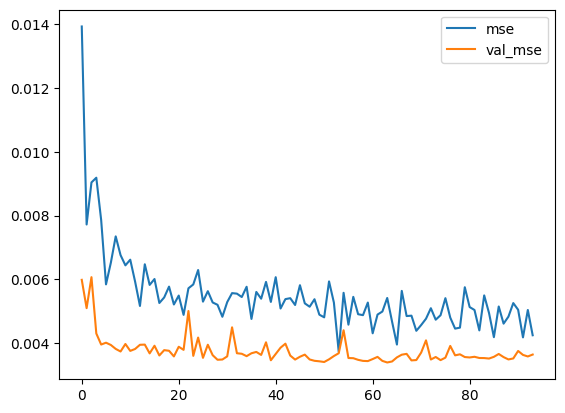

accuracy test: 
16/16 [==============================] - 0s 6ms/step - loss: 0.0077 - mse: 0.0077
Pearsons correlation: 0.725
Pearsons correlation on scaled vals: 0.725


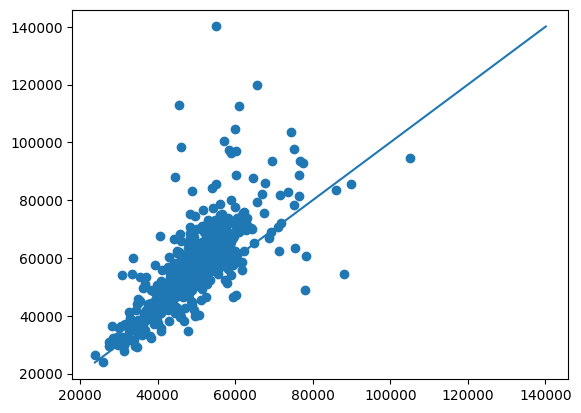

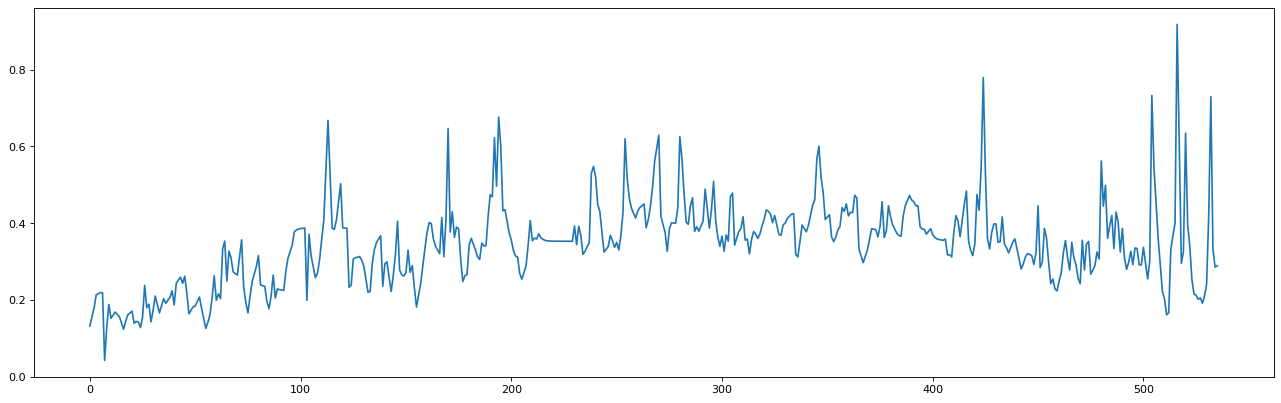

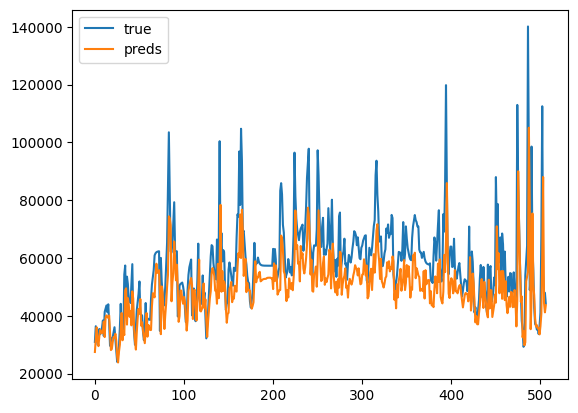

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 30, 6)]           0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                18176     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 18241 (71.25 KB)
Trainable params: 18241 (71.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0175 - mse: 0.0175
Epoch 1: val_loss improved from inf to 0.01371, saving model to saved_model/bfc025ce.x
INFO:tensorflow:Assets written to: saved_model/bfc025ce.x/assets


INFO:tensorflow:Assets written to: saved_model/bfc025ce.x/assets


25/25 [==============================] - 4s 101ms/step - loss: 0.0175 - mse: 0.0175 - val_loss: 0.0137 - val_mse: 0.0137 - lr: 0.0010
Epoch 2/512
21/25 [========================>.....] - ETA: 0s - loss: 0.0110 - mse: 0.0110
Epoch 2: val_loss improved from 0.01371 to 0.01017, saving model to saved_model/bfc025ce.x
INFO:tensorflow:Assets written to: saved_model/bfc025ce.x/assets


INFO:tensorflow:Assets written to: saved_model/bfc025ce.x/assets


25/25 [==============================] - 2s 90ms/step - loss: 0.0111 - mse: 0.0111 - val_loss: 0.0102 - val_mse: 0.0102 - lr: 0.0010
Epoch 3/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0100 - mse: 0.0100
Epoch 3: val_loss improved from 0.01017 to 0.00909, saving model to saved_model/bfc025ce.x
INFO:tensorflow:Assets written to: saved_model/bfc025ce.x/assets


INFO:tensorflow:Assets written to: saved_model/bfc025ce.x/assets


25/25 [==============================] - 2s 101ms/step - loss: 0.0095 - mse: 0.0095 - val_loss: 0.0091 - val_mse: 0.0091 - lr: 0.0010
Epoch 4/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0076 - mse: 0.0076
Epoch 4: val_loss did not improve from 0.00909
25/25 [==============================] - 0s 13ms/step - loss: 0.0083 - mse: 0.0083 - val_loss: 0.0094 - val_mse: 0.0094 - lr: 0.0010
Epoch 5/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0086 - mse: 0.0086
Epoch 5: val_loss improved from 0.00909 to 0.00859, saving model to saved_model/bfc025ce.x
INFO:tensorflow:Assets written to: saved_model/bfc025ce.x/assets


INFO:tensorflow:Assets written to: saved_model/bfc025ce.x/assets


25/25 [==============================] - 2s 88ms/step - loss: 0.0082 - mse: 0.0082 - val_loss: 0.0086 - val_mse: 0.0086 - lr: 0.0010
Epoch 6/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0090 - mse: 0.0090
Epoch 6: val_loss did not improve from 0.00859
25/25 [==============================] - 0s 14ms/step - loss: 0.0087 - mse: 0.0087 - val_loss: 0.0088 - val_mse: 0.0088 - lr: 0.0010
Epoch 7/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0062 - mse: 0.0062
Epoch 7: val_loss improved from 0.00859 to 0.00821, saving model to saved_model/bfc025ce.x
INFO:tensorflow:Assets written to: saved_model/bfc025ce.x/assets


INFO:tensorflow:Assets written to: saved_model/bfc025ce.x/assets


25/25 [==============================] - 2s 88ms/step - loss: 0.0066 - mse: 0.0066 - val_loss: 0.0082 - val_mse: 0.0082 - lr: 0.0010
Epoch 8/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0074 - mse: 0.0074
Epoch 8: val_loss improved from 0.00821 to 0.00813, saving model to saved_model/bfc025ce.x
INFO:tensorflow:Assets written to: saved_model/bfc025ce.x/assets


INFO:tensorflow:Assets written to: saved_model/bfc025ce.x/assets


25/25 [==============================] - 2s 101ms/step - loss: 0.0073 - mse: 0.0073 - val_loss: 0.0081 - val_mse: 0.0081 - lr: 0.0010
Epoch 9/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0068 - mse: 0.0068
Epoch 9: val_loss improved from 0.00813 to 0.00796, saving model to saved_model/bfc025ce.x
INFO:tensorflow:Assets written to: saved_model/bfc025ce.x/assets


INFO:tensorflow:Assets written to: saved_model/bfc025ce.x/assets


25/25 [==============================] - 2s 88ms/step - loss: 0.0070 - mse: 0.0070 - val_loss: 0.0080 - val_mse: 0.0080 - lr: 0.0010
Epoch 10/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0077 - mse: 0.0077
Epoch 10: val_loss improved from 0.00796 to 0.00765, saving model to saved_model/bfc025ce.x
INFO:tensorflow:Assets written to: saved_model/bfc025ce.x/assets


INFO:tensorflow:Assets written to: saved_model/bfc025ce.x/assets


25/25 [==============================] - 2s 101ms/step - loss: 0.0079 - mse: 0.0079 - val_loss: 0.0076 - val_mse: 0.0076 - lr: 0.0010
Epoch 11/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0065 - mse: 0.0065
Epoch 11: val_loss improved from 0.00765 to 0.00741, saving model to saved_model/bfc025ce.x
INFO:tensorflow:Assets written to: saved_model/bfc025ce.x/assets


INFO:tensorflow:Assets written to: saved_model/bfc025ce.x/assets


25/25 [==============================] - 2s 88ms/step - loss: 0.0063 - mse: 0.0063 - val_loss: 0.0074 - val_mse: 0.0074 - lr: 0.0010
Epoch 12/512
23/25 [==========================>...] - ETA: 0s - loss: 0.0069 - mse: 0.0069
Epoch 12: val_loss improved from 0.00741 to 0.00730, saving model to saved_model/bfc025ce.x
INFO:tensorflow:Assets written to: saved_model/bfc025ce.x/assets


INFO:tensorflow:Assets written to: saved_model/bfc025ce.x/assets


25/25 [==============================] - 3s 128ms/step - loss: 0.0069 - mse: 0.0069 - val_loss: 0.0073 - val_mse: 0.0073 - lr: 0.0010
Epoch 13/512
20/25 [=======================>......] - ETA: 0s - loss: 0.0061 - mse: 0.0061
Epoch 13: val_loss improved from 0.00730 to 0.00707, saving model to saved_model/bfc025ce.x
INFO:tensorflow:Assets written to: saved_model/bfc025ce.x/assets


INFO:tensorflow:Assets written to: saved_model/bfc025ce.x/assets


25/25 [==============================] - 3s 106ms/step - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0071 - val_mse: 0.0071 - lr: 0.0010
Epoch 14/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0068 - mse: 0.0068
Epoch 14: val_loss improved from 0.00707 to 0.00694, saving model to saved_model/bfc025ce.x
INFO:tensorflow:Assets written to: saved_model/bfc025ce.x/assets


INFO:tensorflow:Assets written to: saved_model/bfc025ce.x/assets


25/25 [==============================] - 2s 89ms/step - loss: 0.0067 - mse: 0.0067 - val_loss: 0.0069 - val_mse: 0.0069 - lr: 0.0010
Epoch 15/512
21/25 [========================>.....] - ETA: 0s - loss: 0.0076 - mse: 0.0076
Epoch 15: val_loss improved from 0.00694 to 0.00687, saving model to saved_model/bfc025ce.x
INFO:tensorflow:Assets written to: saved_model/bfc025ce.x/assets


INFO:tensorflow:Assets written to: saved_model/bfc025ce.x/assets


25/25 [==============================] - 2s 88ms/step - loss: 0.0075 - mse: 0.0075 - val_loss: 0.0069 - val_mse: 0.0069 - lr: 0.0010
Epoch 16/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0052 - mse: 0.0052
Epoch 16: val_loss improved from 0.00687 to 0.00664, saving model to saved_model/bfc025ce.x
INFO:tensorflow:Assets written to: saved_model/bfc025ce.x/assets


INFO:tensorflow:Assets written to: saved_model/bfc025ce.x/assets


25/25 [==============================] - 3s 106ms/step - loss: 0.0054 - mse: 0.0054 - val_loss: 0.0066 - val_mse: 0.0066 - lr: 0.0010
Epoch 17/512
21/25 [========================>.....] - ETA: 0s - loss: 0.0068 - mse: 0.0068
Epoch 17: val_loss improved from 0.00664 to 0.00660, saving model to saved_model/bfc025ce.x
INFO:tensorflow:Assets written to: saved_model/bfc025ce.x/assets


INFO:tensorflow:Assets written to: saved_model/bfc025ce.x/assets


25/25 [==============================] - 2s 88ms/step - loss: 0.0069 - mse: 0.0069 - val_loss: 0.0066 - val_mse: 0.0066 - lr: 0.0010
Epoch 18/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0062 - mse: 0.0062
Epoch 18: val_loss improved from 0.00660 to 0.00638, saving model to saved_model/bfc025ce.x
INFO:tensorflow:Assets written to: saved_model/bfc025ce.x/assets


INFO:tensorflow:Assets written to: saved_model/bfc025ce.x/assets


25/25 [==============================] - 2s 89ms/step - loss: 0.0063 - mse: 0.0063 - val_loss: 0.0064 - val_mse: 0.0064 - lr: 0.0010
Epoch 19/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0073 - mse: 0.0073
Epoch 19: val_loss did not improve from 0.00638
25/25 [==============================] - 0s 13ms/step - loss: 0.0078 - mse: 0.0078 - val_loss: 0.0086 - val_mse: 0.0086 - lr: 0.0010
Epoch 20/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0055 - mse: 0.0055
Epoch 20: val_loss did not improve from 0.00638
25/25 [==============================] - 0s 13ms/step - loss: 0.0054 - mse: 0.0054 - val_loss: 0.0078 - val_mse: 0.0078 - lr: 0.0010
Epoch 21/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0068 - mse: 0.0068
Epoch 21: val_loss improved from 0.00638 to 0.00632, saving model to saved_model/bfc025ce.x
INFO:tensorflow:Assets written to: saved_model/bfc025ce.x/assets


INFO:tensorflow:Assets written to: saved_model/bfc025ce.x/assets


25/25 [==============================] - 2s 102ms/step - loss: 0.0068 - mse: 0.0068 - val_loss: 0.0063 - val_mse: 0.0063 - lr: 0.0010
Epoch 22/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0058 - mse: 0.0058
Epoch 22: val_loss improved from 0.00632 to 0.00606, saving model to saved_model/bfc025ce.x
INFO:tensorflow:Assets written to: saved_model/bfc025ce.x/assets


INFO:tensorflow:Assets written to: saved_model/bfc025ce.x/assets


25/25 [==============================] - 2s 88ms/step - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0061 - val_mse: 0.0061 - lr: 0.0010
Epoch 23/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0061 - mse: 0.0061
Epoch 23: val_loss did not improve from 0.00606
25/25 [==============================] - 0s 14ms/step - loss: 0.0063 - mse: 0.0063 - val_loss: 0.0064 - val_mse: 0.0064 - lr: 0.0010
Epoch 24/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0062 - mse: 0.0062
Epoch 24: val_loss did not improve from 0.00606
25/25 [==============================] - 0s 13ms/step - loss: 0.0061 - mse: 0.0061 - val_loss: 0.0062 - val_mse: 0.0062 - lr: 0.0010
Epoch 25/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0055 - mse: 0.0055
Epoch 25: val_loss improved from 0.00606 to 0.00602, saving model to saved_model/bfc025ce.x
INFO:tensorflow:Assets written to: saved_model/bfc025ce.x/assets


INFO:tensorflow:Assets written to: saved_model/bfc025ce.x/assets


25/25 [==============================] - 2s 88ms/step - loss: 0.0054 - mse: 0.0054 - val_loss: 0.0060 - val_mse: 0.0060 - lr: 0.0010
Epoch 26/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0060 - mse: 0.0060
Epoch 26: val_loss did not improve from 0.00602
25/25 [==============================] - 0s 14ms/step - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0063 - val_mse: 0.0063 - lr: 0.0010
Epoch 27/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0054 - mse: 0.0054
Epoch 27: val_loss improved from 0.00602 to 0.00577, saving model to saved_model/bfc025ce.x
INFO:tensorflow:Assets written to: saved_model/bfc025ce.x/assets


INFO:tensorflow:Assets written to: saved_model/bfc025ce.x/assets


25/25 [==============================] - 3s 103ms/step - loss: 0.0056 - mse: 0.0056 - val_loss: 0.0058 - val_mse: 0.0058 - lr: 0.0010
Epoch 28/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0057 - mse: 0.0057
Epoch 28: val_loss improved from 0.00577 to 0.00563, saving model to saved_model/bfc025ce.x
INFO:tensorflow:Assets written to: saved_model/bfc025ce.x/assets


INFO:tensorflow:Assets written to: saved_model/bfc025ce.x/assets


25/25 [==============================] - 2s 87ms/step - loss: 0.0054 - mse: 0.0054 - val_loss: 0.0056 - val_mse: 0.0056 - lr: 0.0010
Epoch 29/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0065 - mse: 0.0065
Epoch 29: val_loss improved from 0.00563 to 0.00562, saving model to saved_model/bfc025ce.x
INFO:tensorflow:Assets written to: saved_model/bfc025ce.x/assets


INFO:tensorflow:Assets written to: saved_model/bfc025ce.x/assets


25/25 [==============================] - 2s 88ms/step - loss: 0.0063 - mse: 0.0063 - val_loss: 0.0056 - val_mse: 0.0056 - lr: 0.0010
Epoch 30/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0054 - mse: 0.0054
Epoch 30: val_loss did not improve from 0.00562
25/25 [==============================] - 0s 13ms/step - loss: 0.0062 - mse: 0.0062 - val_loss: 0.0060 - val_mse: 0.0060 - lr: 0.0010
Epoch 31/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0054 - mse: 0.0054
Epoch 31: val_loss did not improve from 0.00562
25/25 [==============================] - 0s 13ms/step - loss: 0.0055 - mse: 0.0055 - val_loss: 0.0060 - val_mse: 0.0060 - lr: 0.0010
Epoch 32/512
21/25 [========================>.....] - ETA: 0s - loss: 0.0059 - mse: 0.0059
Epoch 32: val_loss improved from 0.00562 to 0.00557, saving model to saved_model/bfc025ce.x
INFO:tensorflow:Assets written to: saved_model/bfc025ce.x/assets


INFO:tensorflow:Assets written to: saved_model/bfc025ce.x/assets


25/25 [==============================] - 2s 103ms/step - loss: 0.0058 - mse: 0.0058 - val_loss: 0.0056 - val_mse: 0.0056 - lr: 0.0010
Epoch 33/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0059 - mse: 0.0059
Epoch 33: val_loss improved from 0.00557 to 0.00550, saving model to saved_model/bfc025ce.x
INFO:tensorflow:Assets written to: saved_model/bfc025ce.x/assets


INFO:tensorflow:Assets written to: saved_model/bfc025ce.x/assets


25/25 [==============================] - 2s 88ms/step - loss: 0.0054 - mse: 0.0054 - val_loss: 0.0055 - val_mse: 0.0055 - lr: 0.0010
Epoch 34/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0057 - mse: 0.0057
Epoch 34: val_loss did not improve from 0.00550
25/25 [==============================] - 0s 14ms/step - loss: 0.0054 - mse: 0.0054 - val_loss: 0.0057 - val_mse: 0.0057 - lr: 0.0010
Epoch 35/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0047 - mse: 0.0047
Epoch 35: val_loss did not improve from 0.00550
25/25 [==============================] - 0s 13ms/step - loss: 0.0053 - mse: 0.0053 - val_loss: 0.0055 - val_mse: 0.0055 - lr: 0.0010
Epoch 36/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0051 - mse: 0.0051
Epoch 36: val_loss improved from 0.00550 to 0.00534, saving model to saved_model/bfc025ce.x
INFO:tensorflow:Assets written to: saved_model/bfc025ce.x/assets


INFO:tensorflow:Assets written to: saved_model/bfc025ce.x/assets


25/25 [==============================] - 2s 87ms/step - loss: 0.0052 - mse: 0.0052 - val_loss: 0.0053 - val_mse: 0.0053 - lr: 0.0010
Epoch 37/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0059 - mse: 0.0059
Epoch 37: val_loss did not improve from 0.00534
25/25 [==============================] - 0s 14ms/step - loss: 0.0058 - mse: 0.0058 - val_loss: 0.0054 - val_mse: 0.0054 - lr: 0.0010
Epoch 38/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0065 - mse: 0.0065
Epoch 38: val_loss did not improve from 0.00534
25/25 [==============================] - 0s 13ms/step - loss: 0.0063 - mse: 0.0063 - val_loss: 0.0057 - val_mse: 0.0057 - lr: 0.0010
Epoch 39/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0052 - mse: 0.0052
Epoch 39: val_loss improved from 0.00534 to 0.00510, saving model to saved_model/bfc025ce.x
INFO:tensorflow:Assets written to: saved_model/bfc025ce.x/assets


INFO:tensorflow:Assets written to: saved_model/bfc025ce.x/assets


25/25 [==============================] - 3s 104ms/step - loss: 0.0050 - mse: 0.0050 - val_loss: 0.0051 - val_mse: 0.0051 - lr: 0.0010
Epoch 40/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0063 - mse: 0.0063
Epoch 40: val_loss did not improve from 0.00510
25/25 [==============================] - 0s 14ms/step - loss: 0.0058 - mse: 0.0058 - val_loss: 0.0056 - val_mse: 0.0056 - lr: 0.0010
Epoch 41/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0048 - mse: 0.0048
Epoch 41: val_loss did not improve from 0.00510
25/25 [==============================] - 0s 14ms/step - loss: 0.0047 - mse: 0.0047 - val_loss: 0.0053 - val_mse: 0.0053 - lr: 0.0010
Epoch 42/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0049 - mse: 0.0049
Epoch 42: val_loss did not improve from 0.00510
25/25 [==============================] - 0s 14ms/step - loss: 0.0053 - mse: 0.0053 - val_loss: 0.0056 - val_mse: 0.0056 - lr: 0.0010
Epoch 43/512
22/25 [=========================>....

INFO:tensorflow:Assets written to: saved_model/bfc025ce.x/assets


25/25 [==============================] - 2s 88ms/step - loss: 0.0061 - mse: 0.0061 - val_loss: 0.0050 - val_mse: 0.0050 - lr: 0.0010
Epoch 50/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0063 - mse: 0.0063
Epoch 50: val_loss did not improve from 0.00504
25/25 [==============================] - 0s 13ms/step - loss: 0.0061 - mse: 0.0061 - val_loss: 0.0054 - val_mse: 0.0054 - lr: 0.0010
Epoch 51/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0064 - mse: 0.0064
Epoch 51: val_loss did not improve from 0.00504
25/25 [==============================] - 0s 14ms/step - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0052 - val_mse: 0.0052 - lr: 0.0010
Epoch 52/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0040 - mse: 0.0040
Epoch 52: val_loss did not improve from 0.00504
25/25 [==============================] - 0s 13ms/step - loss: 0.0042 - mse: 0.0042 - val_loss: 0.0051 - val_mse: 0.0051 - lr: 0.0010
Epoch 53/512
22/25 [=========================>....]

INFO:tensorflow:Assets written to: saved_model/bfc025ce.x/assets


25/25 [==============================] - 2s 90ms/step - loss: 0.0053 - mse: 0.0053 - val_loss: 0.0048 - val_mse: 0.0048 - lr: 0.0010
Epoch 60/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0060 - mse: 0.0060
Epoch 60: val_loss did not improve from 0.00484
25/25 [==============================] - 0s 13ms/step - loss: 0.0059 - mse: 0.0059 - val_loss: 0.0050 - val_mse: 0.0050 - lr: 0.0010
Epoch 61/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0042 - mse: 0.0042
Epoch 61: val_loss did not improve from 0.00484
25/25 [==============================] - 0s 13ms/step - loss: 0.0047 - mse: 0.0047 - val_loss: 0.0049 - val_mse: 0.0049 - lr: 0.0010
Epoch 62/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0044 - mse: 0.0044
Epoch 62: val_loss did not improve from 0.00484
25/25 [==============================] - 0s 13ms/step - loss: 0.0044 - mse: 0.0044 - val_loss: 0.0049 - val_mse: 0.0049 - lr: 0.0010
Epoch 63/512
22/25 [=========================>....]

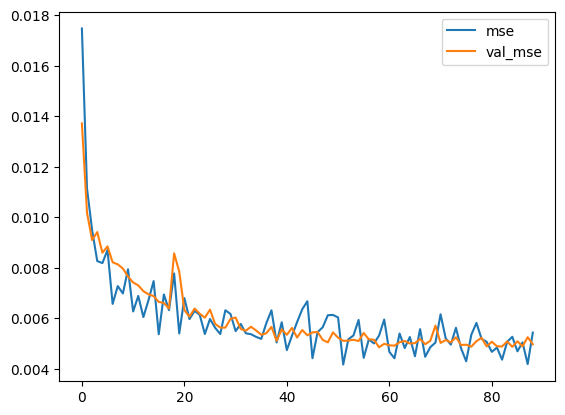

accuracy test: 
16/16 [==============================] - 0s 6ms/step - loss: 0.0056 - mse: 0.0056
Pearsons correlation: 0.733
Pearsons correlation on scaled vals: 0.733


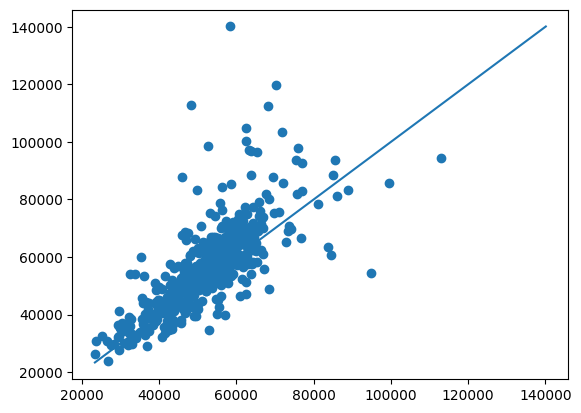

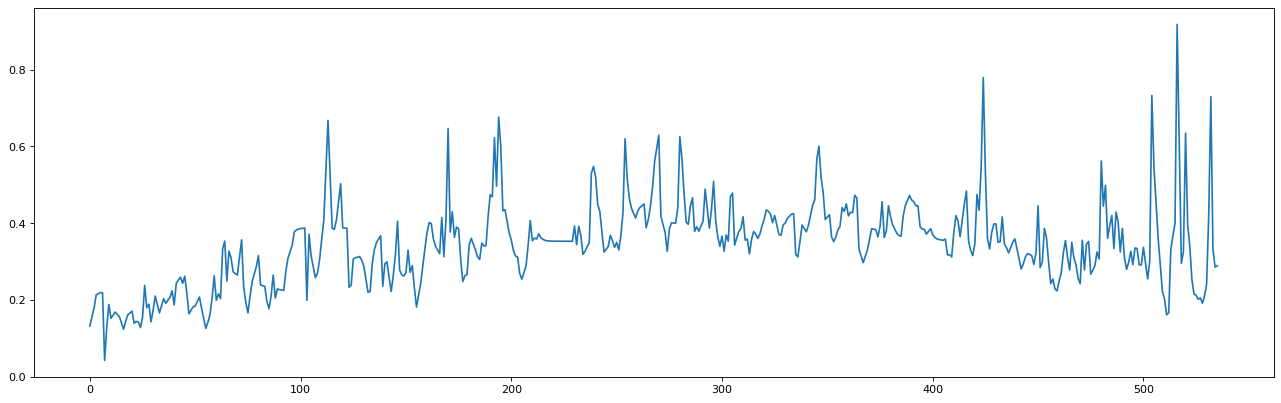

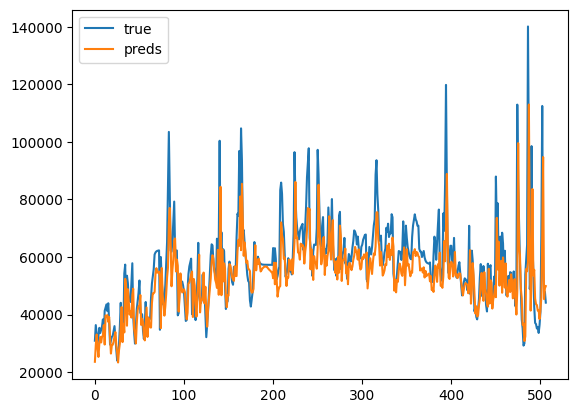

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 30, 6)]           0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                18176     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 18241 (71.25 KB)
Trainable params: 18241 (71.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0350 - mse: 0.0350
Epoch 1: val_loss improved from inf to 0.01016, saving model to saved_model/c1f6b3a5.x
INFO:tensorflow:Assets written to: saved_model/c1f6b3a5.x/assets


INFO:tensorflow:Assets written to: saved_model/c1f6b3a5.x/assets


25/25 [==============================] - 4s 129ms/step - loss: 0.0329 - mse: 0.0329 - val_loss: 0.0102 - val_mse: 0.0102 - lr: 0.0010
Epoch 2/512
23/25 [==========================>...] - ETA: 0s - loss: 0.0117 - mse: 0.0117
Epoch 2: val_loss improved from 0.01016 to 0.00579, saving model to saved_model/c1f6b3a5.x
INFO:tensorflow:Assets written to: saved_model/c1f6b3a5.x/assets


INFO:tensorflow:Assets written to: saved_model/c1f6b3a5.x/assets


25/25 [==============================] - 3s 106ms/step - loss: 0.0114 - mse: 0.0114 - val_loss: 0.0058 - val_mse: 0.0058 - lr: 0.0010
Epoch 3/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0089 - mse: 0.0089
Epoch 3: val_loss improved from 0.00579 to 0.00565, saving model to saved_model/c1f6b3a5.x
INFO:tensorflow:Assets written to: saved_model/c1f6b3a5.x/assets


INFO:tensorflow:Assets written to: saved_model/c1f6b3a5.x/assets


25/25 [==============================] - 3s 109ms/step - loss: 0.0083 - mse: 0.0083 - val_loss: 0.0057 - val_mse: 0.0057 - lr: 0.0010
Epoch 4/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0092 - mse: 0.0092
Epoch 4: val_loss improved from 0.00565 to 0.00551, saving model to saved_model/c1f6b3a5.x
INFO:tensorflow:Assets written to: saved_model/c1f6b3a5.x/assets


INFO:tensorflow:Assets written to: saved_model/c1f6b3a5.x/assets


25/25 [==============================] - 2s 88ms/step - loss: 0.0090 - mse: 0.0090 - val_loss: 0.0055 - val_mse: 0.0055 - lr: 0.0010
Epoch 5/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0077 - mse: 0.0077
Epoch 5: val_loss improved from 0.00551 to 0.00490, saving model to saved_model/c1f6b3a5.x
INFO:tensorflow:Assets written to: saved_model/c1f6b3a5.x/assets


INFO:tensorflow:Assets written to: saved_model/c1f6b3a5.x/assets


25/25 [==============================] - 2s 89ms/step - loss: 0.0078 - mse: 0.0078 - val_loss: 0.0049 - val_mse: 0.0049 - lr: 0.0010
Epoch 6/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0099 - mse: 0.0099
Epoch 6: val_loss improved from 0.00490 to 0.00459, saving model to saved_model/c1f6b3a5.x
INFO:tensorflow:Assets written to: saved_model/c1f6b3a5.x/assets


INFO:tensorflow:Assets written to: saved_model/c1f6b3a5.x/assets


25/25 [==============================] - 3s 104ms/step - loss: 0.0096 - mse: 0.0096 - val_loss: 0.0046 - val_mse: 0.0046 - lr: 0.0010
Epoch 7/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0070 - mse: 0.0070
Epoch 7: val_loss did not improve from 0.00459
25/25 [==============================] - 0s 14ms/step - loss: 0.0070 - mse: 0.0070 - val_loss: 0.0048 - val_mse: 0.0048 - lr: 0.0010
Epoch 8/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0078 - mse: 0.0078
Epoch 8: val_loss improved from 0.00459 to 0.00433, saving model to saved_model/c1f6b3a5.x
INFO:tensorflow:Assets written to: saved_model/c1f6b3a5.x/assets


INFO:tensorflow:Assets written to: saved_model/c1f6b3a5.x/assets


25/25 [==============================] - 2s 89ms/step - loss: 0.0074 - mse: 0.0074 - val_loss: 0.0043 - val_mse: 0.0043 - lr: 0.0010
Epoch 9/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0088 - mse: 0.0088
Epoch 9: val_loss did not improve from 0.00433
25/25 [==============================] - 0s 15ms/step - loss: 0.0089 - mse: 0.0089 - val_loss: 0.0045 - val_mse: 0.0045 - lr: 0.0010
Epoch 10/512
24/25 [===========================>..] - ETA: 0s - loss: 0.0067 - mse: 0.0067
Epoch 10: val_loss did not improve from 0.00433
25/25 [==============================] - 0s 15ms/step - loss: 0.0067 - mse: 0.0067 - val_loss: 0.0043 - val_mse: 0.0043 - lr: 0.0010
Epoch 11/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0081 - mse: 0.0081
Epoch 11: val_loss improved from 0.00433 to 0.00416, saving model to saved_model/c1f6b3a5.x
INFO:tensorflow:Assets written to: saved_model/c1f6b3a5.x/assets


INFO:tensorflow:Assets written to: saved_model/c1f6b3a5.x/assets


25/25 [==============================] - 2s 88ms/step - loss: 0.0081 - mse: 0.0081 - val_loss: 0.0042 - val_mse: 0.0042 - lr: 0.0010
Epoch 12/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0078 - mse: 0.0078
Epoch 12: val_loss improved from 0.00416 to 0.00413, saving model to saved_model/c1f6b3a5.x
INFO:tensorflow:Assets written to: saved_model/c1f6b3a5.x/assets


INFO:tensorflow:Assets written to: saved_model/c1f6b3a5.x/assets


25/25 [==============================] - 3s 103ms/step - loss: 0.0076 - mse: 0.0076 - val_loss: 0.0041 - val_mse: 0.0041 - lr: 0.0010
Epoch 13/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0073 - mse: 0.0073
Epoch 13: val_loss improved from 0.00413 to 0.00398, saving model to saved_model/c1f6b3a5.x
INFO:tensorflow:Assets written to: saved_model/c1f6b3a5.x/assets


INFO:tensorflow:Assets written to: saved_model/c1f6b3a5.x/assets


25/25 [==============================] - 2s 88ms/step - loss: 0.0069 - mse: 0.0069 - val_loss: 0.0040 - val_mse: 0.0040 - lr: 0.0010
Epoch 14/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0070 - mse: 0.0070
Epoch 14: val_loss did not improve from 0.00398
25/25 [==============================] - 0s 14ms/step - loss: 0.0073 - mse: 0.0073 - val_loss: 0.0041 - val_mse: 0.0041 - lr: 0.0010
Epoch 15/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0075 - mse: 0.0075
Epoch 15: val_loss did not improve from 0.00398
25/25 [==============================] - 0s 14ms/step - loss: 0.0076 - mse: 0.0076 - val_loss: 0.0040 - val_mse: 0.0040 - lr: 0.0010
Epoch 16/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0067 - mse: 0.0067
Epoch 16: val_loss improved from 0.00398 to 0.00375, saving model to saved_model/c1f6b3a5.x
INFO:tensorflow:Assets written to: saved_model/c1f6b3a5.x/assets


INFO:tensorflow:Assets written to: saved_model/c1f6b3a5.x/assets


25/25 [==============================] - 2s 102ms/step - loss: 0.0067 - mse: 0.0067 - val_loss: 0.0038 - val_mse: 0.0038 - lr: 0.0010
Epoch 17/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0076 - mse: 0.0076
Epoch 17: val_loss improved from 0.00375 to 0.00362, saving model to saved_model/c1f6b3a5.x
INFO:tensorflow:Assets written to: saved_model/c1f6b3a5.x/assets


INFO:tensorflow:Assets written to: saved_model/c1f6b3a5.x/assets


25/25 [==============================] - 2s 89ms/step - loss: 0.0072 - mse: 0.0072 - val_loss: 0.0036 - val_mse: 0.0036 - lr: 0.0010
Epoch 18/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0055 - mse: 0.0055
Epoch 18: val_loss improved from 0.00362 to 0.00360, saving model to saved_model/c1f6b3a5.x
INFO:tensorflow:Assets written to: saved_model/c1f6b3a5.x/assets


INFO:tensorflow:Assets written to: saved_model/c1f6b3a5.x/assets


25/25 [==============================] - 2s 89ms/step - loss: 0.0062 - mse: 0.0062 - val_loss: 0.0036 - val_mse: 0.0036 - lr: 0.0010
Epoch 19/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0066 - mse: 0.0066
Epoch 19: val_loss did not improve from 0.00360
25/25 [==============================] - 0s 14ms/step - loss: 0.0066 - mse: 0.0066 - val_loss: 0.0036 - val_mse: 0.0036 - lr: 0.0010
Epoch 20/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0062 - mse: 0.0062
Epoch 20: val_loss did not improve from 0.00360
25/25 [==============================] - 0s 13ms/step - loss: 0.0064 - mse: 0.0064 - val_loss: 0.0039 - val_mse: 0.0039 - lr: 0.0010
Epoch 21/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0064 - mse: 0.0064
Epoch 21: val_loss improved from 0.00360 to 0.00350, saving model to saved_model/c1f6b3a5.x
INFO:tensorflow:Assets written to: saved_model/c1f6b3a5.x/assets


INFO:tensorflow:Assets written to: saved_model/c1f6b3a5.x/assets


25/25 [==============================] - 2s 89ms/step - loss: 0.0065 - mse: 0.0065 - val_loss: 0.0035 - val_mse: 0.0035 - lr: 0.0010
Epoch 22/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0071 - mse: 0.0071
Epoch 22: val_loss did not improve from 0.00350
25/25 [==============================] - 0s 13ms/step - loss: 0.0070 - mse: 0.0070 - val_loss: 0.0037 - val_mse: 0.0037 - lr: 0.0010
Epoch 23/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0056 - mse: 0.0056
Epoch 23: val_loss did not improve from 0.00350
25/25 [==============================] - 0s 13ms/step - loss: 0.0052 - mse: 0.0052 - val_loss: 0.0035 - val_mse: 0.0035 - lr: 0.0010
Epoch 24/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0064 - mse: 0.0064
Epoch 24: val_loss did not improve from 0.00350
25/25 [==============================] - 0s 14ms/step - loss: 0.0066 - mse: 0.0066 - val_loss: 0.0038 - val_mse: 0.0038 - lr: 0.0010
Epoch 25/512
22/25 [=========================>....]

INFO:tensorflow:Assets written to: saved_model/c1f6b3a5.x/assets


25/25 [==============================] - 3s 105ms/step - loss: 0.0059 - mse: 0.0059 - val_loss: 0.0035 - val_mse: 0.0035 - lr: 0.0010
Epoch 26/512
21/25 [========================>.....] - ETA: 0s - loss: 0.0053 - mse: 0.0053
Epoch 26: val_loss did not improve from 0.00349
25/25 [==============================] - 0s 14ms/step - loss: 0.0053 - mse: 0.0053 - val_loss: 0.0037 - val_mse: 0.0037 - lr: 0.0010
Epoch 27/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0051 - mse: 0.0051
Epoch 27: val_loss improved from 0.00349 to 0.00344, saving model to saved_model/c1f6b3a5.x
INFO:tensorflow:Assets written to: saved_model/c1f6b3a5.x/assets


INFO:tensorflow:Assets written to: saved_model/c1f6b3a5.x/assets


25/25 [==============================] - 2s 89ms/step - loss: 0.0052 - mse: 0.0052 - val_loss: 0.0034 - val_mse: 0.0034 - lr: 0.0010
Epoch 28/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0060 - mse: 0.0060
Epoch 28: val_loss did not improve from 0.00344
25/25 [==============================] - 0s 14ms/step - loss: 0.0061 - mse: 0.0061 - val_loss: 0.0036 - val_mse: 0.0036 - lr: 0.0010
Epoch 29/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0063 - mse: 0.0063
Epoch 29: val_loss improved from 0.00344 to 0.00339, saving model to saved_model/c1f6b3a5.x
INFO:tensorflow:Assets written to: saved_model/c1f6b3a5.x/assets


INFO:tensorflow:Assets written to: saved_model/c1f6b3a5.x/assets


25/25 [==============================] - 2s 89ms/step - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0034 - val_mse: 0.0034 - lr: 0.0010
Epoch 30/512
21/25 [========================>.....] - ETA: 0s - loss: 0.0057 - mse: 0.0057
Epoch 30: val_loss did not improve from 0.00339
25/25 [==============================] - 0s 14ms/step - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0034 - val_mse: 0.0034 - lr: 0.0010
Epoch 31/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0050 - mse: 0.0050
Epoch 31: val_loss did not improve from 0.00339
25/25 [==============================] - 0s 14ms/step - loss: 0.0050 - mse: 0.0050 - val_loss: 0.0035 - val_mse: 0.0035 - lr: 0.0010
Epoch 32/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0059 - mse: 0.0059
Epoch 32: val_loss did not improve from 0.00339
25/25 [==============================] - 0s 14ms/step - loss: 0.0059 - mse: 0.0059 - val_loss: 0.0035 - val_mse: 0.0035 - lr: 0.0010
Epoch 33/512
21/25 [========================>.....]

INFO:tensorflow:Assets written to: saved_model/c1f6b3a5.x/assets


25/25 [==============================] - 3s 104ms/step - loss: 0.0059 - mse: 0.0059 - val_loss: 0.0032 - val_mse: 0.0032 - lr: 0.0010
Epoch 36/512
21/25 [========================>.....] - ETA: 0s - loss: 0.0055 - mse: 0.0055
Epoch 36: val_loss did not improve from 0.00325
25/25 [==============================] - 0s 14ms/step - loss: 0.0052 - mse: 0.0052 - val_loss: 0.0038 - val_mse: 0.0038 - lr: 0.0010
Epoch 37/512
21/25 [========================>.....] - ETA: 0s - loss: 0.0063 - mse: 0.0063
Epoch 37: val_loss improved from 0.00325 to 0.00321, saving model to saved_model/c1f6b3a5.x
INFO:tensorflow:Assets written to: saved_model/c1f6b3a5.x/assets


INFO:tensorflow:Assets written to: saved_model/c1f6b3a5.x/assets


25/25 [==============================] - 2s 90ms/step - loss: 0.0059 - mse: 0.0059 - val_loss: 0.0032 - val_mse: 0.0032 - lr: 0.0010
Epoch 38/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0042 - mse: 0.0042
Epoch 38: val_loss did not improve from 0.00321
25/25 [==============================] - 0s 17ms/step - loss: 0.0041 - mse: 0.0041 - val_loss: 0.0033 - val_mse: 0.0033 - lr: 0.0010
Epoch 39/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0056 - mse: 0.0056
Epoch 39: val_loss did not improve from 0.00321
25/25 [==============================] - 0s 17ms/step - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0033 - val_mse: 0.0033 - lr: 0.0010
Epoch 40/512
24/25 [===========================>..] - ETA: 0s - loss: 0.0063 - mse: 0.0063
Epoch 40: val_loss did not improve from 0.00321
25/25 [==============================] - 0s 17ms/step - loss: 0.0062 - mse: 0.0062 - val_loss: 0.0033 - val_mse: 0.0033 - lr: 0.0010
Epoch 41/512
22/25 [=========================>....]

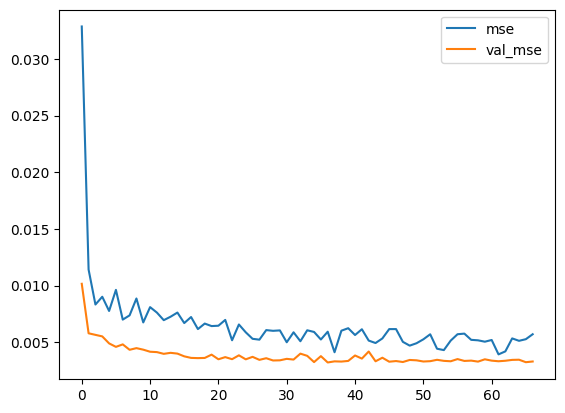

accuracy test: 
16/16 [==============================] - 0s 6ms/step - loss: 0.0054 - mse: 0.0054
Pearsons correlation: 0.730
Pearsons correlation on scaled vals: 0.730


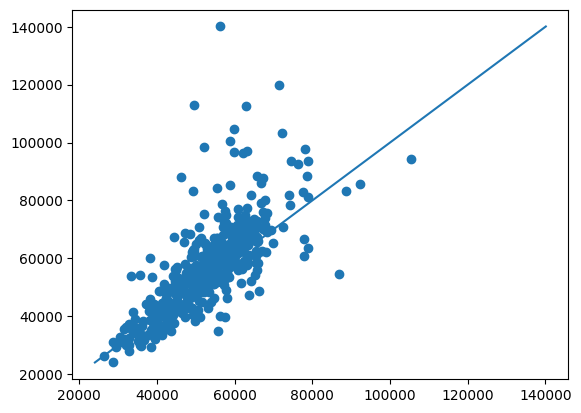

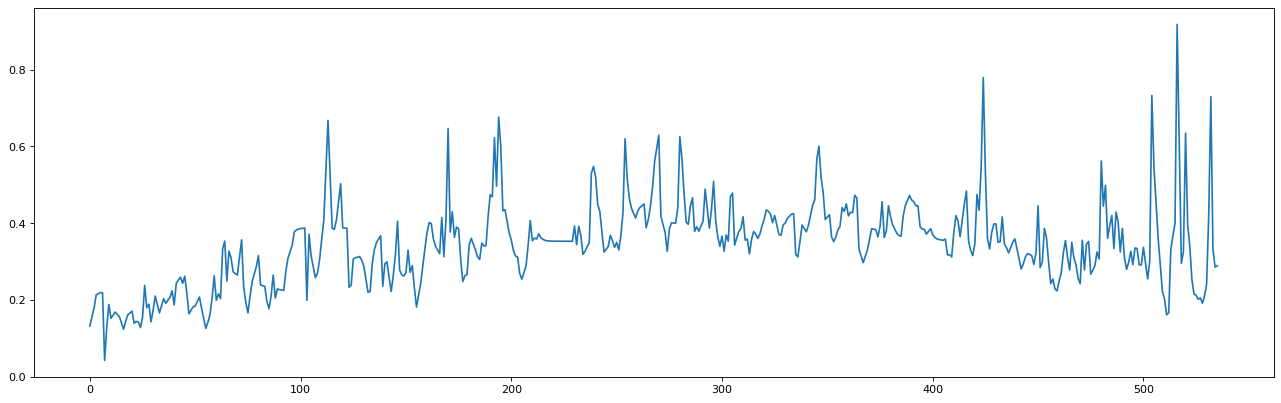

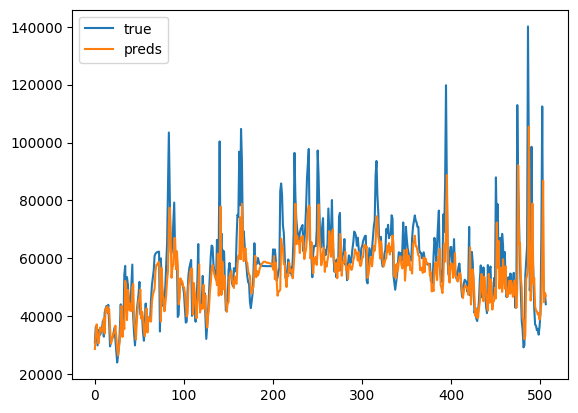

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 30, 6)]           0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                18176     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 18241 (71.25 KB)
Trainable params: 18241 (71.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0147 - mse: 0.0147
Epoch 1: val_loss improved from inf to 0.00955, saving model to saved_model/8d996073.x
INFO:tensorflow:Assets written to: saved_model/8d996073.x/assets


INFO:tensorflow:Assets written to: saved_model/8d996073.x/assets


25/25 [==============================] - 4s 118ms/step - loss: 0.0140 - mse: 0.0140 - val_loss: 0.0095 - val_mse: 0.0095 - lr: 0.0010
Epoch 2/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0094 - mse: 0.0094
Epoch 2: val_loss improved from 0.00955 to 0.00855, saving model to saved_model/8d996073.x
INFO:tensorflow:Assets written to: saved_model/8d996073.x/assets


INFO:tensorflow:Assets written to: saved_model/8d996073.x/assets


25/25 [==============================] - 2s 89ms/step - loss: 0.0090 - mse: 0.0090 - val_loss: 0.0085 - val_mse: 0.0085 - lr: 0.0010
Epoch 3/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0091 - mse: 0.0091
Epoch 3: val_loss improved from 0.00855 to 0.00804, saving model to saved_model/8d996073.x
INFO:tensorflow:Assets written to: saved_model/8d996073.x/assets


INFO:tensorflow:Assets written to: saved_model/8d996073.x/assets


25/25 [==============================] - 3s 103ms/step - loss: 0.0087 - mse: 0.0087 - val_loss: 0.0080 - val_mse: 0.0080 - lr: 0.0010
Epoch 4/512
21/25 [========================>.....] - ETA: 0s - loss: 0.0078 - mse: 0.0078
Epoch 4: val_loss improved from 0.00804 to 0.00791, saving model to saved_model/8d996073.x
INFO:tensorflow:Assets written to: saved_model/8d996073.x/assets


INFO:tensorflow:Assets written to: saved_model/8d996073.x/assets


25/25 [==============================] - 2s 88ms/step - loss: 0.0080 - mse: 0.0080 - val_loss: 0.0079 - val_mse: 0.0079 - lr: 0.0010
Epoch 5/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0075 - mse: 0.0075
Epoch 5: val_loss improved from 0.00791 to 0.00768, saving model to saved_model/8d996073.x
INFO:tensorflow:Assets written to: saved_model/8d996073.x/assets


INFO:tensorflow:Assets written to: saved_model/8d996073.x/assets


25/25 [==============================] - 2s 89ms/step - loss: 0.0076 - mse: 0.0076 - val_loss: 0.0077 - val_mse: 0.0077 - lr: 0.0010
Epoch 6/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0068 - mse: 0.0068
Epoch 6: val_loss did not improve from 0.00768
25/25 [==============================] - 0s 14ms/step - loss: 0.0070 - mse: 0.0070 - val_loss: 0.0083 - val_mse: 0.0083 - lr: 0.0010
Epoch 7/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0079 - mse: 0.0079
Epoch 7: val_loss improved from 0.00768 to 0.00722, saving model to saved_model/8d996073.x
INFO:tensorflow:Assets written to: saved_model/8d996073.x/assets


INFO:tensorflow:Assets written to: saved_model/8d996073.x/assets


25/25 [==============================] - 2s 88ms/step - loss: 0.0079 - mse: 0.0079 - val_loss: 0.0072 - val_mse: 0.0072 - lr: 0.0010
Epoch 8/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0073 - mse: 0.0073
Epoch 8: val_loss did not improve from 0.00722
25/25 [==============================] - 0s 14ms/step - loss: 0.0068 - mse: 0.0068 - val_loss: 0.0074 - val_mse: 0.0074 - lr: 0.0010
Epoch 9/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0075 - mse: 0.0075
Epoch 9: val_loss improved from 0.00722 to 0.00701, saving model to saved_model/8d996073.x
INFO:tensorflow:Assets written to: saved_model/8d996073.x/assets


INFO:tensorflow:Assets written to: saved_model/8d996073.x/assets


25/25 [==============================] - 3s 108ms/step - loss: 0.0071 - mse: 0.0071 - val_loss: 0.0070 - val_mse: 0.0070 - lr: 0.0010
Epoch 10/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0061 - mse: 0.0061
Epoch 10: val_loss improved from 0.00701 to 0.00690, saving model to saved_model/8d996073.x
INFO:tensorflow:Assets written to: saved_model/8d996073.x/assets


INFO:tensorflow:Assets written to: saved_model/8d996073.x/assets


25/25 [==============================] - 2s 89ms/step - loss: 0.0064 - mse: 0.0064 - val_loss: 0.0069 - val_mse: 0.0069 - lr: 0.0010
Epoch 11/512
19/25 [=====================>........] - ETA: 0s - loss: 0.0064 - mse: 0.0064
Epoch 11: val_loss did not improve from 0.00690
25/25 [==============================] - 0s 14ms/step - loss: 0.0061 - mse: 0.0061 - val_loss: 0.0072 - val_mse: 0.0072 - lr: 0.0010
Epoch 12/512
21/25 [========================>.....] - ETA: 0s - loss: 0.0064 - mse: 0.0064
Epoch 12: val_loss did not improve from 0.00690
25/25 [==============================] - 0s 14ms/step - loss: 0.0059 - mse: 0.0059 - val_loss: 0.0075 - val_mse: 0.0075 - lr: 0.0010
Epoch 13/512
21/25 [========================>.....] - ETA: 0s - loss: 0.0070 - mse: 0.0070
Epoch 13: val_loss did not improve from 0.00690
25/25 [==============================] - 0s 14ms/step - loss: 0.0073 - mse: 0.0073 - val_loss: 0.0078 - val_mse: 0.0078 - lr: 0.0010
Epoch 14/512
20/25 [=======================>......]

INFO:tensorflow:Assets written to: saved_model/8d996073.x/assets


25/25 [==============================] - 2s 94ms/step - loss: 0.0055 - mse: 0.0055 - val_loss: 0.0066 - val_mse: 0.0066 - lr: 0.0010
Epoch 16/512
19/25 [=====================>........] - ETA: 0s - loss: 0.0060 - mse: 0.0060
Epoch 16: val_loss improved from 0.00660 to 0.00641, saving model to saved_model/8d996073.x
INFO:tensorflow:Assets written to: saved_model/8d996073.x/assets


INFO:tensorflow:Assets written to: saved_model/8d996073.x/assets


25/25 [==============================] - 3s 105ms/step - loss: 0.0062 - mse: 0.0062 - val_loss: 0.0064 - val_mse: 0.0064 - lr: 0.0010
Epoch 17/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0052 - mse: 0.0052
Epoch 17: val_loss improved from 0.00641 to 0.00614, saving model to saved_model/8d996073.x
INFO:tensorflow:Assets written to: saved_model/8d996073.x/assets


INFO:tensorflow:Assets written to: saved_model/8d996073.x/assets


25/25 [==============================] - 3s 142ms/step - loss: 0.0062 - mse: 0.0062 - val_loss: 0.0061 - val_mse: 0.0061 - lr: 0.0010
Epoch 18/512
21/25 [========================>.....] - ETA: 0s - loss: 0.0070 - mse: 0.0070
Epoch 18: val_loss improved from 0.00614 to 0.00609, saving model to saved_model/8d996073.x
INFO:tensorflow:Assets written to: saved_model/8d996073.x/assets


INFO:tensorflow:Assets written to: saved_model/8d996073.x/assets


25/25 [==============================] - 2s 89ms/step - loss: 0.0069 - mse: 0.0069 - val_loss: 0.0061 - val_mse: 0.0061 - lr: 0.0010
Epoch 19/512
20/25 [=======================>......] - ETA: 0s - loss: 0.0051 - mse: 0.0051
Epoch 19: val_loss improved from 0.00609 to 0.00598, saving model to saved_model/8d996073.x
INFO:tensorflow:Assets written to: saved_model/8d996073.x/assets


INFO:tensorflow:Assets written to: saved_model/8d996073.x/assets


25/25 [==============================] - 3s 108ms/step - loss: 0.0051 - mse: 0.0051 - val_loss: 0.0060 - val_mse: 0.0060 - lr: 0.0010
Epoch 20/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0068 - mse: 0.0068
Epoch 20: val_loss did not improve from 0.00598
25/25 [==============================] - 0s 14ms/step - loss: 0.0071 - mse: 0.0071 - val_loss: 0.0061 - val_mse: 0.0061 - lr: 0.0010
Epoch 21/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0063 - mse: 0.0063
Epoch 21: val_loss did not improve from 0.00598
25/25 [==============================] - 0s 14ms/step - loss: 0.0061 - mse: 0.0061 - val_loss: 0.0060 - val_mse: 0.0060 - lr: 0.0010
Epoch 22/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0055 - mse: 0.0055
Epoch 22: val_loss did not improve from 0.00598
25/25 [==============================] - 0s 14ms/step - loss: 0.0053 - mse: 0.0053 - val_loss: 0.0064 - val_mse: 0.0064 - lr: 0.0010
Epoch 23/512
22/25 [=========================>....

INFO:tensorflow:Assets written to: saved_model/8d996073.x/assets


25/25 [==============================] - 2s 90ms/step - loss: 0.0062 - mse: 0.0062 - val_loss: 0.0059 - val_mse: 0.0059 - lr: 0.0010
Epoch 27/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0049 - mse: 0.0049
Epoch 27: val_loss did not improve from 0.00595
25/25 [==============================] - 0s 14ms/step - loss: 0.0049 - mse: 0.0049 - val_loss: 0.0062 - val_mse: 0.0062 - lr: 0.0010
Epoch 28/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0058 - mse: 0.0058
Epoch 28: val_loss improved from 0.00595 to 0.00566, saving model to saved_model/8d996073.x
INFO:tensorflow:Assets written to: saved_model/8d996073.x/assets


INFO:tensorflow:Assets written to: saved_model/8d996073.x/assets


25/25 [==============================] - 2s 91ms/step - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0057 - val_mse: 0.0057 - lr: 0.0010
Epoch 29/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0056 - mse: 0.0056
Epoch 29: val_loss did not improve from 0.00566
25/25 [==============================] - 0s 14ms/step - loss: 0.0058 - mse: 0.0058 - val_loss: 0.0059 - val_mse: 0.0059 - lr: 0.0010
Epoch 30/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0051 - mse: 0.0051
Epoch 30: val_loss did not improve from 0.00566
25/25 [==============================] - 0s 13ms/step - loss: 0.0052 - mse: 0.0052 - val_loss: 0.0057 - val_mse: 0.0057 - lr: 0.0010
Epoch 31/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0062 - mse: 0.0062
Epoch 31: val_loss did not improve from 0.00566
25/25 [==============================] - 0s 14ms/step - loss: 0.0061 - mse: 0.0061 - val_loss: 0.0059 - val_mse: 0.0059 - lr: 0.0010
Epoch 32/512
21/25 [========================>.....]

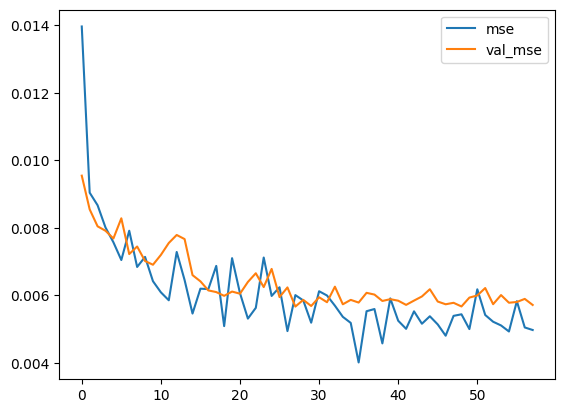

accuracy test: 
16/16 [==============================] - 0s 6ms/step - loss: 0.0068 - mse: 0.0068
Pearsons correlation: 0.725
Pearsons correlation on scaled vals: 0.725


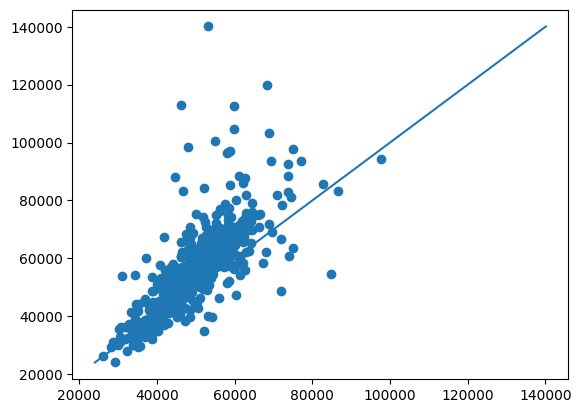

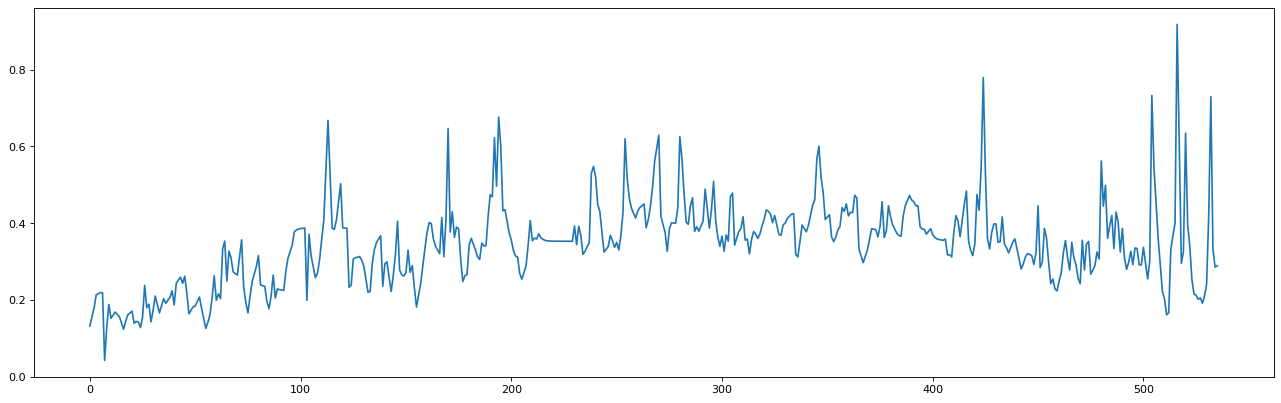

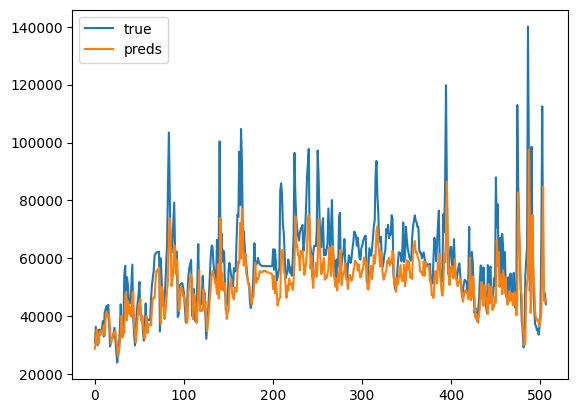

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 30, 6)]           0         
                                                                 
 lstm_4 (LSTM)               (None, 64)                18176     
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 18241 (71.25 KB)
Trainable params: 18241 (71.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0408 - mse: 0.0408
Epoch 1: val_loss improved from inf to 0.01633, saving model to saved_model/3056a92c.x
INFO:tensorflow:Assets written to: saved_model/3056a92c.x/assets


INFO:tensorflow:Assets written to: saved_model/3056a92c.x/assets


25/25 [==============================] - 4s 102ms/step - loss: 0.0384 - mse: 0.0384 - val_loss: 0.0163 - val_mse: 0.0163 - lr: 0.0010
Epoch 2/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0177 - mse: 0.0177
Epoch 2: val_loss improved from 0.01633 to 0.00996, saving model to saved_model/3056a92c.x
INFO:tensorflow:Assets written to: saved_model/3056a92c.x/assets


INFO:tensorflow:Assets written to: saved_model/3056a92c.x/assets


25/25 [==============================] - 2s 89ms/step - loss: 0.0176 - mse: 0.0176 - val_loss: 0.0100 - val_mse: 0.0100 - lr: 0.0010
Epoch 3/512
21/25 [========================>.....] - ETA: 0s - loss: 0.0133 - mse: 0.0133
Epoch 3: val_loss improved from 0.00996 to 0.00701, saving model to saved_model/3056a92c.x
INFO:tensorflow:Assets written to: saved_model/3056a92c.x/assets


INFO:tensorflow:Assets written to: saved_model/3056a92c.x/assets


25/25 [==============================] - 3s 105ms/step - loss: 0.0126 - mse: 0.0126 - val_loss: 0.0070 - val_mse: 0.0070 - lr: 0.0010
Epoch 4/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0100 - mse: 0.0100
Epoch 4: val_loss did not improve from 0.00701
25/25 [==============================] - 0s 13ms/step - loss: 0.0103 - mse: 0.0103 - val_loss: 0.0072 - val_mse: 0.0072 - lr: 0.0010
Epoch 5/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0086 - mse: 0.0086
Epoch 5: val_loss improved from 0.00701 to 0.00647, saving model to saved_model/3056a92c.x
INFO:tensorflow:Assets written to: saved_model/3056a92c.x/assets


INFO:tensorflow:Assets written to: saved_model/3056a92c.x/assets


25/25 [==============================] - 2s 89ms/step - loss: 0.0083 - mse: 0.0083 - val_loss: 0.0065 - val_mse: 0.0065 - lr: 0.0010
Epoch 6/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0099 - mse: 0.0099
Epoch 6: val_loss improved from 0.00647 to 0.00600, saving model to saved_model/3056a92c.x
INFO:tensorflow:Assets written to: saved_model/3056a92c.x/assets


INFO:tensorflow:Assets written to: saved_model/3056a92c.x/assets


25/25 [==============================] - 2s 89ms/step - loss: 0.0096 - mse: 0.0096 - val_loss: 0.0060 - val_mse: 0.0060 - lr: 0.0010
Epoch 7/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0087 - mse: 0.0087
Epoch 7: val_loss improved from 0.00600 to 0.00600, saving model to saved_model/3056a92c.x
INFO:tensorflow:Assets written to: saved_model/3056a92c.x/assets


INFO:tensorflow:Assets written to: saved_model/3056a92c.x/assets


25/25 [==============================] - 3s 108ms/step - loss: 0.0084 - mse: 0.0084 - val_loss: 0.0060 - val_mse: 0.0060 - lr: 0.0010
Epoch 8/512
21/25 [========================>.....] - ETA: 0s - loss: 0.0074 - mse: 0.0074
Epoch 8: val_loss did not improve from 0.00600
25/25 [==============================] - 0s 14ms/step - loss: 0.0086 - mse: 0.0086 - val_loss: 0.0061 - val_mse: 0.0061 - lr: 0.0010
Epoch 9/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0084 - mse: 0.0084
Epoch 9: val_loss did not improve from 0.00600
25/25 [==============================] - 0s 14ms/step - loss: 0.0091 - mse: 0.0091 - val_loss: 0.0060 - val_mse: 0.0060 - lr: 0.0010
Epoch 10/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0092 - mse: 0.0092
Epoch 10: val_loss improved from 0.00600 to 0.00545, saving model to saved_model/3056a92c.x
INFO:tensorflow:Assets written to: saved_model/3056a92c.x/assets


INFO:tensorflow:Assets written to: saved_model/3056a92c.x/assets


25/25 [==============================] - 2s 90ms/step - loss: 0.0086 - mse: 0.0086 - val_loss: 0.0054 - val_mse: 0.0054 - lr: 0.0010
Epoch 11/512
24/25 [===========================>..] - ETA: 0s - loss: 0.0079 - mse: 0.0079
Epoch 11: val_loss did not improve from 0.00545
25/25 [==============================] - 0s 16ms/step - loss: 0.0078 - mse: 0.0078 - val_loss: 0.0056 - val_mse: 0.0056 - lr: 0.0010
Epoch 12/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0092 - mse: 0.0092
Epoch 12: val_loss did not improve from 0.00545
25/25 [==============================] - 0s 13ms/step - loss: 0.0093 - mse: 0.0093 - val_loss: 0.0056 - val_mse: 0.0056 - lr: 0.0010
Epoch 13/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0080 - mse: 0.0080
Epoch 13: val_loss improved from 0.00545 to 0.00516, saving model to saved_model/3056a92c.x
INFO:tensorflow:Assets written to: saved_model/3056a92c.x/assets


INFO:tensorflow:Assets written to: saved_model/3056a92c.x/assets


25/25 [==============================] - 2s 89ms/step - loss: 0.0078 - mse: 0.0078 - val_loss: 0.0052 - val_mse: 0.0052 - lr: 0.0010
Epoch 14/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0079 - mse: 0.0079
Epoch 14: val_loss did not improve from 0.00516
25/25 [==============================] - 0s 13ms/step - loss: 0.0080 - mse: 0.0080 - val_loss: 0.0056 - val_mse: 0.0056 - lr: 0.0010
Epoch 15/512
20/25 [=======================>......] - ETA: 0s - loss: 0.0095 - mse: 0.0095
Epoch 15: val_loss improved from 0.00516 to 0.00495, saving model to saved_model/3056a92c.x
INFO:tensorflow:Assets written to: saved_model/3056a92c.x/assets


INFO:tensorflow:Assets written to: saved_model/3056a92c.x/assets


25/25 [==============================] - 3s 109ms/step - loss: 0.0093 - mse: 0.0093 - val_loss: 0.0049 - val_mse: 0.0049 - lr: 0.0010
Epoch 16/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0085 - mse: 0.0085
Epoch 16: val_loss did not improve from 0.00495
25/25 [==============================] - 0s 14ms/step - loss: 0.0086 - mse: 0.0086 - val_loss: 0.0056 - val_mse: 0.0056 - lr: 0.0010
Epoch 17/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0070 - mse: 0.0070
Epoch 17: val_loss improved from 0.00495 to 0.00485, saving model to saved_model/3056a92c.x
INFO:tensorflow:Assets written to: saved_model/3056a92c.x/assets


INFO:tensorflow:Assets written to: saved_model/3056a92c.x/assets


25/25 [==============================] - 2s 88ms/step - loss: 0.0070 - mse: 0.0070 - val_loss: 0.0048 - val_mse: 0.0048 - lr: 0.0010
Epoch 18/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0070 - mse: 0.0070
Epoch 18: val_loss did not improve from 0.00485
25/25 [==============================] - 0s 14ms/step - loss: 0.0071 - mse: 0.0071 - val_loss: 0.0052 - val_mse: 0.0052 - lr: 0.0010
Epoch 19/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0069 - mse: 0.0069
Epoch 19: val_loss improved from 0.00485 to 0.00470, saving model to saved_model/3056a92c.x
INFO:tensorflow:Assets written to: saved_model/3056a92c.x/assets


INFO:tensorflow:Assets written to: saved_model/3056a92c.x/assets


25/25 [==============================] - 2s 89ms/step - loss: 0.0071 - mse: 0.0071 - val_loss: 0.0047 - val_mse: 0.0047 - lr: 0.0010
Epoch 20/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0070 - mse: 0.0070
Epoch 20: val_loss did not improve from 0.00470
25/25 [==============================] - 0s 14ms/step - loss: 0.0073 - mse: 0.0073 - val_loss: 0.0053 - val_mse: 0.0053 - lr: 0.0010
Epoch 21/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0063 - mse: 0.0063
Epoch 21: val_loss improved from 0.00470 to 0.00465, saving model to saved_model/3056a92c.x
INFO:tensorflow:Assets written to: saved_model/3056a92c.x/assets


INFO:tensorflow:Assets written to: saved_model/3056a92c.x/assets


25/25 [==============================] - 3s 106ms/step - loss: 0.0064 - mse: 0.0064 - val_loss: 0.0047 - val_mse: 0.0047 - lr: 0.0010
Epoch 22/512
21/25 [========================>.....] - ETA: 0s - loss: 0.0076 - mse: 0.0076
Epoch 22: val_loss did not improve from 0.00465
25/25 [==============================] - 0s 15ms/step - loss: 0.0071 - mse: 0.0071 - val_loss: 0.0049 - val_mse: 0.0049 - lr: 0.0010
Epoch 23/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0083 - mse: 0.0083
Epoch 23: val_loss did not improve from 0.00465
25/25 [==============================] - 0s 14ms/step - loss: 0.0081 - mse: 0.0081 - val_loss: 0.0047 - val_mse: 0.0047 - lr: 0.0010
Epoch 24/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0065 - mse: 0.0065
Epoch 24: val_loss improved from 0.00465 to 0.00460, saving model to saved_model/3056a92c.x
INFO:tensorflow:Assets written to: saved_model/3056a92c.x/assets


INFO:tensorflow:Assets written to: saved_model/3056a92c.x/assets


25/25 [==============================] - 2s 89ms/step - loss: 0.0067 - mse: 0.0067 - val_loss: 0.0046 - val_mse: 0.0046 - lr: 0.0010
Epoch 25/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0070 - mse: 0.0070
Epoch 25: val_loss improved from 0.00460 to 0.00444, saving model to saved_model/3056a92c.x
INFO:tensorflow:Assets written to: saved_model/3056a92c.x/assets


INFO:tensorflow:Assets written to: saved_model/3056a92c.x/assets


25/25 [==============================] - 2s 88ms/step - loss: 0.0067 - mse: 0.0067 - val_loss: 0.0044 - val_mse: 0.0044 - lr: 0.0010
Epoch 26/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0059 - mse: 0.0059
Epoch 26: val_loss improved from 0.00444 to 0.00439, saving model to saved_model/3056a92c.x
INFO:tensorflow:Assets written to: saved_model/3056a92c.x/assets


INFO:tensorflow:Assets written to: saved_model/3056a92c.x/assets


25/25 [==============================] - 2s 88ms/step - loss: 0.0061 - mse: 0.0061 - val_loss: 0.0044 - val_mse: 0.0044 - lr: 0.0010
Epoch 27/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0064 - mse: 0.0064
Epoch 27: val_loss did not improve from 0.00439
25/25 [==============================] - 0s 13ms/step - loss: 0.0061 - mse: 0.0061 - val_loss: 0.0045 - val_mse: 0.0045 - lr: 0.0010
Epoch 28/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0065 - mse: 0.0065
Epoch 28: val_loss improved from 0.00439 to 0.00424, saving model to saved_model/3056a92c.x
INFO:tensorflow:Assets written to: saved_model/3056a92c.x/assets


INFO:tensorflow:Assets written to: saved_model/3056a92c.x/assets


25/25 [==============================] - 3s 130ms/step - loss: 0.0074 - mse: 0.0074 - val_loss: 0.0042 - val_mse: 0.0042 - lr: 0.0010
Epoch 29/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0072 - mse: 0.0072
Epoch 29: val_loss did not improve from 0.00424
25/25 [==============================] - 0s 17ms/step - loss: 0.0068 - mse: 0.0068 - val_loss: 0.0046 - val_mse: 0.0046 - lr: 0.0010
Epoch 30/512
24/25 [===========================>..] - ETA: 0s - loss: 0.0067 - mse: 0.0067
Epoch 30: val_loss did not improve from 0.00424
25/25 [==============================] - 0s 16ms/step - loss: 0.0067 - mse: 0.0067 - val_loss: 0.0043 - val_mse: 0.0043 - lr: 0.0010
Epoch 31/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0069 - mse: 0.0069
Epoch 31: val_loss did not improve from 0.00424
25/25 [==============================] - 0s 13ms/step - loss: 0.0069 - mse: 0.0069 - val_loss: 0.0047 - val_mse: 0.0047 - lr: 0.0010
Epoch 32/512
21/25 [========================>.....

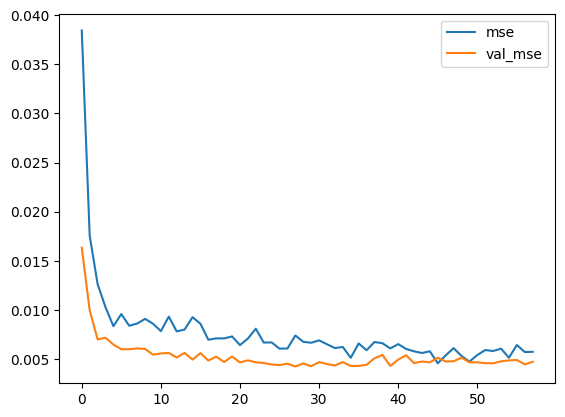

accuracy test: 
16/16 [==============================] - 0s 6ms/step - loss: 0.0060 - mse: 0.0060
Pearsons correlation: 0.735
Pearsons correlation on scaled vals: 0.735


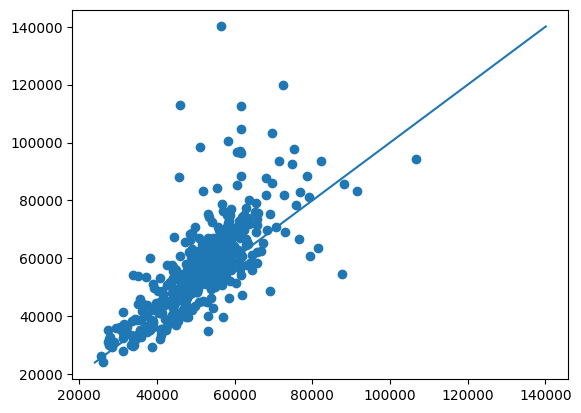

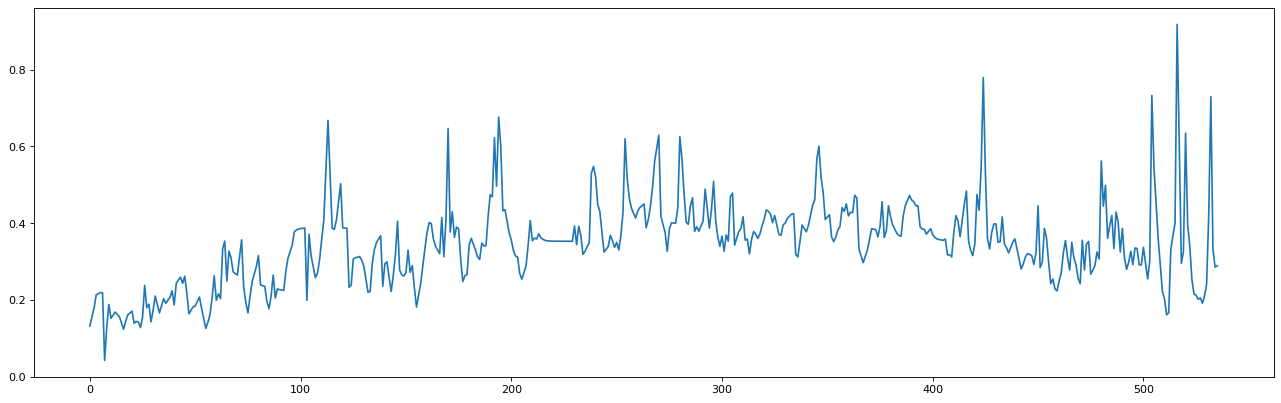

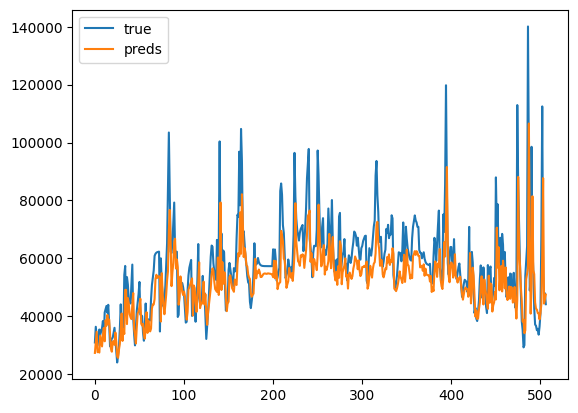

In [5]:


train_filenames, test_filenames = dataset.load_data(shuffle=False)
trainer = ModelTrainer(batch_size=64)
k = 5
kf = KFold(n_splits=k)
print(train_filenames.shape)
epochs = 512
loss = 'mse'
idx = np.arange(len(train_filenames))
np.random.shuffle(idx)
train_filenames = train_filenames[idx]

for train_index, val_index in kf.split(train_filenames):
    model_name =generate_model_name()
    train_fold_filenames, val_fold_filenames = train_filenames[train_index], train_filenames[val_index]
    # Split the training data into training and validation sets for this fold
    train_generator, valid_generator,input_shape, output_shape = dataset.generate_data(train_fold_filenames, val_fold_filenames)
    # genero il modello a che prende in considerazione input ed output shape
    regressor = LSTMRegressor(model_name=model_name)
    regressor.generate_model(input_shape, output_shape)

    # alleno il modello
    trainer.run(
        model=regressor.model,
        model_name=regressor.model_name,
        train={"filenames": train_fold_filenames, "generator": train_generator},
        test={'filenames': val_fold_filenames, 'generator': valid_generator},
        optimizer=Adam(learning_rate=0.001),
        epochs=epochs,
        loss=loss
    )

    print("accuracy test: ")
    _, test_generator, __, ___ = dataset.generate_data(train_filenames, test_filenames)
    lstm_y_preds = regressor.model.predict(test_generator)
    accuracy = regressor.model.evaluate(test_generator)

    scaler_path = 'scalers/'
    X_test, y_test = dataset.generator_to_Xy(test_generator)

    # eval_model.eval(model_name)
    regressor.model.evaluate(test_generator)

    eval_pearsonsr(lstm_y_preds, y_test, remove_outliers=False)

    y_true = y_test.reshape(y_test.shape[0], )
    scaled_y_true = scale_preds(y_true, scaler_path=f'{scaler_path}/Rn_olb_scaler.save')
    scaled_y_preds = scale_preds(lstm_y_preds, scaler_path=f'{scaler_path}/Rn_olb_scaler.save')

    rn = DatasetGenerator.get_ts_from_ds(X_test, -2)
    plt.figure(figsize=(20, 6), dpi=80)
    plt.plot(rn)
    plt.show()

    plt.plot(scaled_y_true, label='true')
    plt.plot(scaled_y_preds, label='preds')
    plt.legend()
    plt.show()

    # ottengo X_train,y_train ed X_test, y_test
    #X_train_fold, y_train_fold = dataset.generator_to_Xy(train_generator)
    #X_val_fold, y_val_fold = dataset.generator_to_Xy(valid_generator)

    #rn = DatasetGenerator.get_ts_from_ds(X_train_fold, y_train_fold, -2)
    #rn_test = DatasetGenerator.get_ts_from_ds(X_val_fold, y_val_fold, -2)
    #plt.figure(figsize=(20,6))
    #plt.plot(rn)
    #plt.figure(figsize=(20,6))
    #plt.plot(rn_test)